# Ball Challenge

Predicting the probability of impact given a three-channel timeseries of acceleration data (x-, y-, z-direction)
- Input: Three-channel acceleration data
    - Assumption: Sampled at 100 Hz and recorded for 3 seconds
- Output: Two-dimensional probability map containing the probability of impact for each cell in a grid
    - Assumption: 10x10 grid

In [1]:
import torch
import torch.nn.functional as F

import seaborn as sns

from elasticai.creator.nn import Sequential as TranslatableSequential
from elasticai.creator.nn.fixed_point import quantize, BatchNormedConv1d, Linear, HardTanh

In [2]:
class ProbabilityMapSoftmax(torch.nn.Module):
    def __init__(self) -> None:
        super().__init__()
    
    def forward(self, inputs: torch.Tensor) -> torch.Tensor:
        *first_dims, height, width = inputs.shape
        vector = inputs.view(*first_dims, height * width)
        probability_vector = F.softmax(vector, dim=len(first_dims))
        probability_map = probability_vector.view(*first_dims, height, width)
        return probability_map

In [3]:
class BallChallengeModel(torch.nn.Module):
    def __init__(
        self,
        total_bits: int,
        frac_bits: int,
        signal_length: int,
        impact_grid_size: tuple[int, int],
    ) -> None:
        super().__init__()
        self.grid_width, self.grid_height = impact_grid_size
        self.total_bits = total_bits
        self.frac_bits = frac_bits
        
        self.hardware_model = TranslatableSequential(
            BatchNormedConv1d(
                in_channels=3,
                out_channels=32,
                signal_length=signal_length,
                kernel_size=8,
                total_bits=total_bits,
                frac_bits=frac_bits,
            ),
            HardTanh(total_bits=total_bits, frac_bits=frac_bits),
            BatchNormedConv1d(
                in_channels=32,
                out_channels=4,
                signal_length=signal_length - 7,
                kernel_size=4,
                total_bits=total_bits,
                frac_bits=frac_bits,
            ),
            HardTanh(total_bits=total_bits, frac_bits=frac_bits),
            Linear(
                in_features=(signal_length - 10) * 4,
                out_features=self.grid_width * self.grid_height,
                bias=True,
                total_bits=total_bits,
                frac_bits=frac_bits,
            ),
        )
        self.softmax = ProbabilityMapSoftmax()
    
    def forward(self, inputs: torch.Tensor) -> torch.Tensor:
        *first_dims, height, width = inputs.shape
        inputs = inputs.view(*first_dims, width * height)

        quantized_inputs = quantize(inputs, total_bits=self.total_bits, frac_bits=self.frac_bits)
        predictions = self.hardware_model(quantized_inputs)
        prediction_map = predictions.view(*first_dims, self.grid_height, self.grid_width)

        return self.softmax(prediction_map)        

In [4]:
sampling_freq = 100
recording_time = 3
num_channels = 3

model = BallChallengeModel(
    total_bits=16,
    frac_bits=8,
    signal_length=sampling_freq * recording_time,
    impact_grid_size=(10, 10),
)

random_inputs = torch.randn(num_channels, sampling_freq * recording_time)
predicted_impact_map = model(random_inputs).detach()

<Axes: >

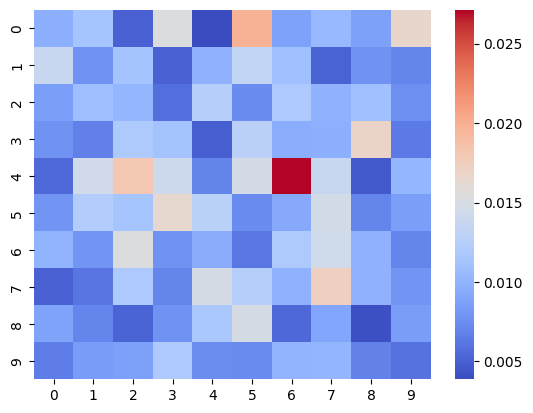

In [5]:
sns.heatmap(predicted_impact_map, cmap="coolwarm")